In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
DATA_PATH = "../../FPGA/core/simulation/modelsim/data/"

video_file = "church.mp4"
# video_file = "aperol.mp4"


In [3]:
TOTAL_LINES = 525
TOTAL_ACTIVE_LINES = 480
TOTAL_PIXELS = 858
TOTAL_ACTIVE_PIXELS = 720
TOTAL_BLANKING_PIXELS = TOTAL_PIXELS - TOTAL_ACTIVE_PIXELS

preamble = [0xFF, 0x00, 0x00]
# https://pub.smpte.org/pub/st293/st0293-2003_stable2010.pdf, table 3
SAV_active = 0b10000000
EAV_active = 0b10011101
SAV_VBI = 0b10101011
EAV_VBI = 0b10110110

EAV_START = 2 * TOTAL_ACTIVE_PIXELS
SAV_START =  2 * TOTAL_PIXELS - 4

DEFAULT_Y = 16
DEFAULT_C = 128
# what is going on during vertical blanking?
# todo do for one frame

## Converting mp4 to bt656

In [486]:
cap = cv2.VideoCapture(video_file)
global_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3), np.uint8)

counter = 0
all_frames = []
while (1):
    ret, frame = cap.read()

    if cv2.waitKey(1) & 0xFF == ord('q') or ret == False:
        cap.release()
        cv2.destroyAllWindows()
        break

    frame = cv2.resize(frame, (720, 480), cv2.INTER_AREA)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    frame = np.clip(frame, 1, 254)

    lines = np.zeros((TOTAL_LINES, 2 * TOTAL_PIXELS)).astype(np.uint8)
    # YCrCb 4:2:2
    Y = frame[:, :, 0]
    Cr = frame[:, ::2, 1]
    Cb = frame[:, ::2, 2]

    lines[:, 0::2] = DEFAULT_C
    lines[:, 1::2] = DEFAULT_Y
    
    lines[:, EAV_START: EAV_START + 3] = preamble
    lines[:, SAV_START: SAV_START + 3] = preamble

    lines[:TOTAL_ACTIVE_LINES, EAV_START + 3] = EAV_active
    lines[:TOTAL_ACTIVE_LINES, SAV_START + 3] = SAV_active


    lines[TOTAL_ACTIVE_LINES:, EAV_START + 3] = EAV_VBI
    lines[TOTAL_ACTIVE_LINES:, SAV_START + 3] = SAV_VBI

    lines[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4] = Cr
    lines[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2] = Y
    lines[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4] = Cb


    

    x_roll = 4
    lines = np.roll(lines, x_roll)
    lines[0][x_roll-1] = SAV_active
    lines[-1][EAV_START + 4 + x_roll - 1] = EAV_active
    lines = np.roll(lines, TOTAL_LINES - TOTAL_ACTIVE_LINES, 0)
    # lines[TOTAL_LINES - TOTAL_ACTIVE_LINES - 1][2*TOTAL_ACTIVE_PIXELS + 4 - 1] = SAV_active
    lines[0][x_roll-1] = SAV_VBI
    lines[-1][EAV_START + 4 + x_roll - 1] = EAV_VBI



    # Cr = lines[:, 0::4]
    # Y  = lines[:, 1::2]
    # Cb = lines[:, 2::4]
    # 
    # Cr = np.repeat(Cr, 2, axis=1)
    # Cb = np.repeat(Cb, 2, axis=1)
    # new_frame = np.zeros((TOTAL_LINES, TOTAL_PIXELS, 3)).astype(np.uint8)
    # new_frame[:,:,0] = Y
    # new_frame[:,:,1] = Cr
    # new_frame[:,:,2] = Cb
    # cv2.imshow('frame', cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR))

    cv2.imshow('frame', lines)
    # if cv2.waitKey(0) & 0xFF == ord('q'):
    #     cv2.destroyAllWindows()
    #     break
    lines = lines.flatten()
    all_frames.append(lines)


    counter += 1

In [7]:
len(all_frames)

218

In [487]:
with open(f"{os.path.splitext(video_file)[0]}_f{len(all_frames)}.bin", "wb") as fd:
    fd.write(np.array(all_frames).flatten())

In [225]:
del all_frames

## Converting bt656 to mp4

In [5]:
def bt656_to_bgr(frame, roll_x = True, roll_y = True):
    frame = np.array(frame)
    if (roll_x):
        frame = np.roll(frame, -4)
    if (roll_y):
        frame = np.roll(frame, -(TOTAL_LINES - TOTAL_ACTIVE_LINES), 0)

    frame = frame[:TOTAL_ACTIVE_LINES, :2 * TOTAL_ACTIVE_PIXELS]
    Cr = frame[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4]
    Y  = frame[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2]
    Cb = frame[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4]
    
    Cr = np.repeat(Cr, 2, axis=1)
    Cb = np.repeat(Cb, 2, axis=1)
    new_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3)).astype(np.uint8)
    new_frame[:,:,0] = Y
    new_frame[:,:,1] = Cr
    new_frame[:,:,2] = Cb
    
    frame = cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR)
    return frame

In [6]:

def decode_and_display_video(video_file_name, decode_bt656 = True, slow_down_coeff = 1, max_frames = None, return_all_frames=False, save_video = False):
    with open(video_file_name, "rb") as fd:
        all_frames_read =  fd.read()
    all_frames_read = np.array([*all_frames_read])
    i_prev1 = 0
    el_prev3 = None
    el_prev2 = None
    el_prev1 = None
    first_sav = None
    last_eav = None
    sav_cnt = 0
    for i, el in enumerate(all_frames_read):
        # print(el_prev3, el_prev2, el_prev1, el)
        if (el_prev3 == preamble[0] 
                and el_prev2 == preamble[1] 
                and el_prev1 == preamble[2] 
                and (el == SAV_active or el == SAV_VBI)):
            first_sav = i
            sav_cnt += 1
            if sav_cnt == 1:
                break
        if (el_prev3 == preamble[0]
                and el_prev2 == preamble[1]
                and el_prev1 == preamble[2]
                and (el == EAV_active)):
            last_eav = i
        el_prev3 = el_prev2
        el_prev2 = el_prev1
        el_prev1 = el
    # print(first_sav,last_eav)
    points_per_frame = TOTAL_LINES * 2 * TOTAL_PIXELS
    all_frames_read = all_frames_read[first_sav - 3:]
    all_frames_read = all_frames_read[:((len(all_frames_read))//points_per_frame)*points_per_frame]
    all_frames_read =  np.reshape(all_frames_read, (-1, points_per_frame)).astype(np.uint8)
    # if return_all_frames:
    frames = []
    if save_video:
        postfix = ""
        if not decode_bt656:
            postfix = "_bt656"
        save_path = os.path.splitext(os.path.basename(video_file_name))[0] + postfix + ".mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(save_path, fourcc, int(np.ceil(30*slow_down_coeff)), (TOTAL_ACTIVE_PIXELS, TOTAL_ACTIVE_LINES))
    try:
        if max_frames is None:
            max_frames = len(all_frames_read)
        
        max_frames = min(max_frames, len(all_frames_read)) 
        for frame in all_frames_read[:max_frames]:
            
            frame = np.reshape(frame, (TOTAL_LINES, 2 * TOTAL_PIXELS))

            if decode_bt656:
                frame = bt656_to_bgr(frame)
            if return_all_frames:
                frames.append(frame)
            if save_video:
                video.write(frame)
            # frame = frame[:100, :100]
            # frame = cv2.resize(frame, (480, 480))
            cv2.imshow('frame', frame)
            if cv2.waitKey(int(33/slow_down_coeff)) & 0xFF == ord('q'):
                # cap.release()
                cv2.destroyAllWindows()
                if return_all_frames:
                    return frames
                return frame
    except Exception as e:
        print(e)
    finally:
        cv2.destroyAllWindows()
        if return_all_frames:
            return frames
        return frame
        

In [28]:
# with open(os.path.join(DATA_PATH,"video_f60_scrambled_scrambler.bin"), "rb") as f:
#     data = f.read()
# 
# data2 = data[len(data)//2:]
# with open(os.path.join(DATA_PATH,"video_f60_scrambled_scrambler2.bin"), "wb") as f:
#     f.write(data2)


## Visualizations

In [10]:
filename = f"church_f218.bin"
# filename = f"aperol_f84.bin"

frame_normal = decode_and_display_video(os.path.join(DATA_PATH, filename), decode_bt656=True, max_frames=10, slow_down_coeff=0.1)

In [11]:
# filename = "video_f60_descrambled_drbg.bin"
# filename = "church_f10_scrambled_seed0.bin"
# filename = "church_f10_descrambled_seed1234.bin"
filename = "church_f218_scrambled_seed0.bin"
# filename = f"{os.path.splitext(video_file)[0]}_f10_descrambled_seed0.bin"
frame = decode_and_display_video(os.path.join(DATA_PATH,filename), decode_bt656=True, slow_down_coeff=1, save_video=True)

In [12]:
# filename = "video_f60_descrambled_scrambler2.bin"
# filename = "video_f60_descrambled_drbg.bin"
filename = "church_f218_descrambled_seed0.bin"
# filename = "church_f10_descrambled_seed0.bin"
# filename = f"aperol_f84_descrambled_seed0.bin"
frame_decrypted = decode_and_display_video(os.path.join(DATA_PATH, filename), decode_bt656=True, slow_down_coeff=1, save_video=True)

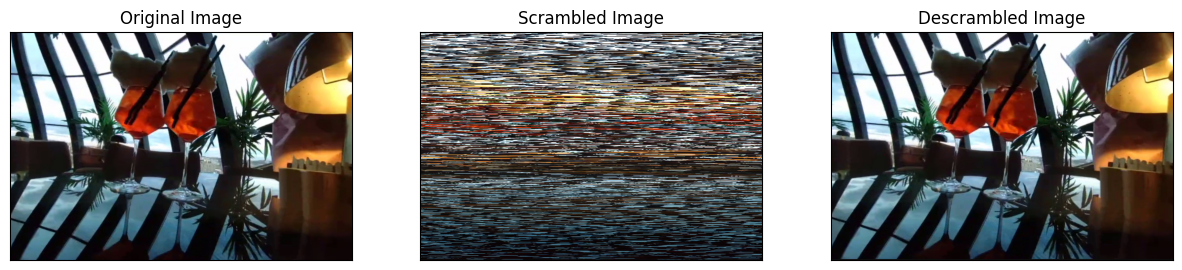

In [570]:

plt.figure(figsize=(15,5))
plt.subplot(131),plt.imshow(cv2.cvtColor(frame_normal, cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Scrambled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cv2.cvtColor(frame_decrypted, cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Descrambled Image'), plt.xticks([]), plt.yticks([])
plt.show()

## Attempt at breaking the scrambler

In [16]:
from  typing import Literal

def get_closest_rotation(reference_line, line):
    distances = []
    rolled_line = line
    for j in range(0, len(line), 1):
        # distances.append(np.linalg.norm(reference_line - rolled_line))
        distances.append(np.sum(np.abs(reference_line - rolled_line)))
        rolled_line = np.roll(rolled_line, 2, axis=0)
    optimal_roll = np.argmin(distances)
    line = np.roll(line, optimal_roll * 2, axis=0)
    return line

def attack_line_rotator_frame(frame, previous_frame_first_reference_line = None, metric: Literal["l1", "entropy"] = "l1"):
    # O(m * n ^ 2) or 360 times slower frame processing
    if (previous_frame_first_reference_line is None):
        reference_line = frame[0]
        unrolled_frame = [reference_line]
        offset = 1
    else:
        reference_line = previous_frame_first_reference_line
        unrolled_frame = []
        offset = 0
    
    for i in range(offset, len(frame)):
        line = frame[i]
        reference_line = get_closest_rotation(reference_line, line)
        unrolled_frame.append(reference_line)
        
    return np.array(unrolled_frame)

def break_line_rotator(frame, convert_to_ycrcb = True):
    if convert_to_ycrcb:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb).astype(int)
    reference_line = frame[0]
    unrolled_frame = [reference_line]
    for i in range(len(frame)):
        line = frame[i]

        reference_line = get_closest_rotation(reference_line, line)
        unrolled_frame.append(reference_line)
    unrolled_frame = np.array(unrolled_frame).astype(np.uint8)
    unrolled_frame = cv2.cvtColor(unrolled_frame, cv2.COLOR_YCrCb2BGR)
    return unrolled_frame

In [17]:
frames = decode_and_display_video(os.path.join(DATA_PATH,"church_f218_scrambled_seed0.bin"), decode_bt656=True, slow_down_coeff=1, return_all_frames=True)
frames =[cv2.cvtColor(i, cv2.COLOR_BGR2YCrCb) for i in frames]

In [18]:
import tqdm
attacked_frames = []
i_prev = None
for i in tqdm.tqdm(frames, position=0, leave=True):
    attacked_frame = attack_line_rotator_frame(i, None if i_prev is None else i_prev[0])
    i_prev = i
    attacked_frames.append(attacked_frame)

100%|██████████| 217/217 [18:26<00:00,  5.10s/it]


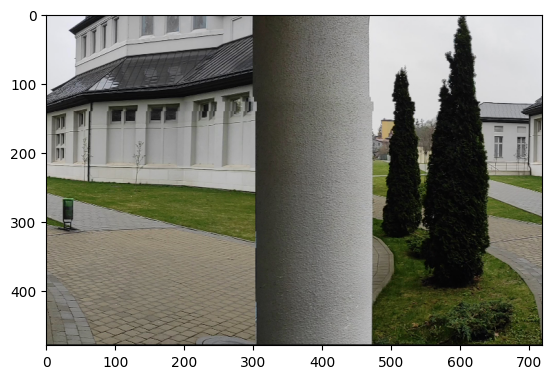

In [21]:
plt.imshow(cv2.cvtColor(attacked_frames[0], cv2.COLOR_YCR_CB2RGB))

In [23]:
slow_down_coeff = 1
write_video = True
# choose codec according to format needed
if write_video:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('church_f218_attacked_seed0.mp4', fourcc, 30, (TOTAL_ACTIVE_PIXELS, TOTAL_ACTIVE_LINES))

    
try:
    for frame in attacked_frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_YCrCb2BGR)
        cv2.imshow('frame', frame)
        if write_video:
            video.write(frame)
        if cv2.waitKey(int(33/slow_down_coeff)) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
finally:
    cv2.destroyAllWindows()
if write_video:
    video.release()


## Entropy calculations

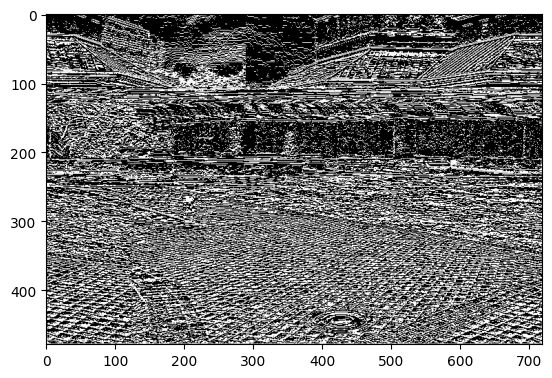

In [274]:
attacked_diff = cv2.cvtColor(attacked_frames[40], cv2.COLOR_BGR2GRAY)

attacked_diff = np.diff(attacked_diff, axis=0)
attacked_diff[attacked_diff < 150] = 0
plt.imshow(attacked_diff, cmap="gray")

(array([186636.,  10567.,   4361.,   2400.,   1311.,   1392.,   2724.,
          4368.,   9942., 121179.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

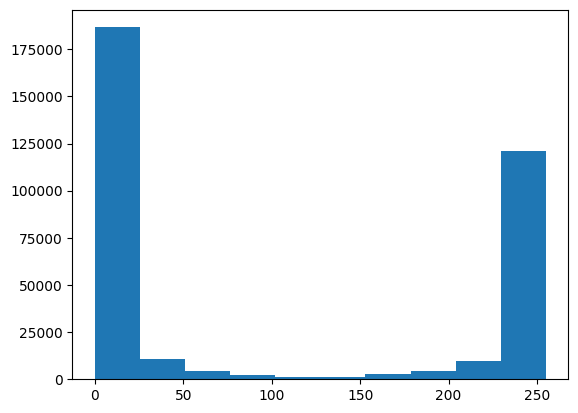

In [265]:
plt.hist(attacked_diff.flatten())

In [41]:
def calculate_detail_entropy(image, raw = False, ycrcb = False):
    if ycrcb:
         image = cv2.cvtColor(image, cv2.COLOR_YCrCb2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) != 2 else image
    if not raw:
        DX = np.diff(image, axis=1)
        DY = np.diff(image, axis=0)
        
        hist_dx = cv2.calcHist([DX], [0], None, [256], [0, 256])
        hist_dx = hist_dx[hist_dx > 0]
        hist_dx /= DX.size
        
        hist_dy = cv2.calcHist([DY], [0], None, [256], [0, 256])
        hist_dy = hist_dy[hist_dy > 0]
        hist_dy /= DY.size
        
        return (-np.sum(hist_dx * np.log2(hist_dx)) + -np.sum(hist_dy * np.log2(hist_dy))) / 2
    else: 
        hist = cv2.calcHist([image], [0], None, [256], [0, 256]) 
        hist = hist[hist > 0]
        hist /= image.size
        return -np.sum(hist * np.log2(hist)) 

In [13]:
descrambled_frames = decode_and_display_video(os.path.join(DATA_PATH,"church_f218_descrambled_seed0.bin"), decode_bt656=True, slow_down_coeff=1, return_all_frames=True)

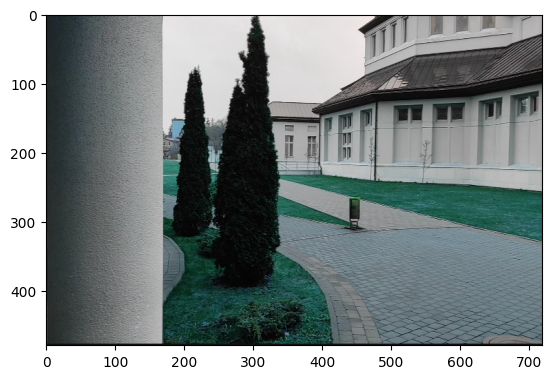

In [40]:
plt.imshow(descrambled_frames[0])

In [90]:
raw_decrypted_entropy, decrypted_entropy, attacked_entropy, encrypted_entropy = zip(*[(
                                             calculate_detail_entropy(descrambled_frames[i], raw=True),
                                             calculate_detail_entropy(descrambled_frames[i]), 
                                             calculate_detail_entropy(attacked_frames[i], ycrcb=True),
                                             calculate_detail_entropy(frames[i], ycrcb=True)) 
                                        for i in range(len(frames))])

Text(0, 0.5, 'Entropy')

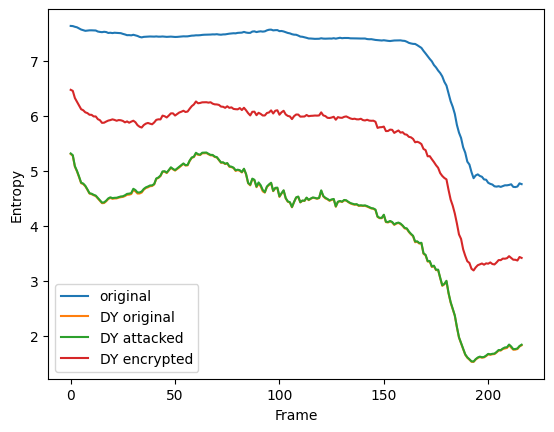

In [91]:
plt.plot(raw_decrypted_entropy)
plt.plot(decrypted_entropy)
plt.plot(attacked_entropy)
plt.plot(encrypted_entropy)
plt.legend(["original", "DY original", "DY attacked", "DY encrypted"])
plt.xlabel("Frame")
plt.ylabel("Entropy")

Text(0, 0.5, 'Entropy')

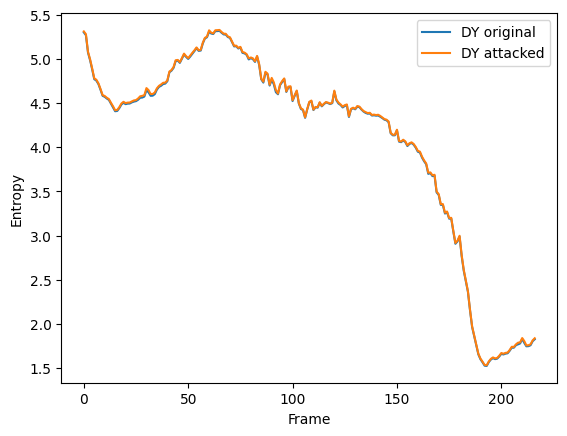

In [93]:
plt.plot(decrypted_entropy)
plt.plot(attacked_entropy)
plt.legend(["DY original", "DY attacked"])
plt.xlabel("Frame")
plt.ylabel("Entropy")

In [22]:
frames_converted = frames

In [105]:
import matplotlib.pyplot as plt

def plot_frame_arrays(frame_arrays, frame_numbers, row_labels, save=False):
    """
    frame_arrays: list of 3 arrays of shape (num_frames, H, W)
    frame_numbers: array of frame numbers to show (length n)
    row_labels: list of 3 strings for labeling each row
    n: number of frames to display per row
    """
    assert len(frame_arrays) == 3
    assert len(row_labels) == 3
    assert len(frame_arrays[0]) > np.max(frame_numbers)
    n = len(frame_numbers)

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(3*3, n*2))
    for row, (frames, label) in enumerate(zip(frame_arrays, row_labels)):
        for col in range(n):
            ax = axes[col, row]
            ax.imshow(cv2.cvtColor(frames[frame_numbers[col]], cv2.COLOR_BGR2RGB), cmap='gray')
            if col == 0:
                ax.set_title(row_labels[row], fontsize=16)
            if row == 0:
                # ax.set_title(f'Frame {frame_numbers[col]}', fontsize=16)
                fig.text(0.03, 1 - 1/(2*n) - col * (1/(n -0.02)), f'Frame {frame_numbers[col]}', va='center', ha='center', rotation='vertical', fontsize=16)
            ax.axis('off')
        # if row == 0:
        #     ax.set_title(row_labels[row], fontsize=16)
        # fig.text(0.03, 0.81 - row * 0.31, row_labels[row], va='center', ha='center', rotation='vertical', fontsize=16)
    plt.tight_layout(rect=[0.03, 0, 1, 1])
    if save:
        plt.savefig("church_SAD.pdf", format="pdf")
    plt.show()

In [50]:
selected_frames = [0, 60, 160, 185, 200]


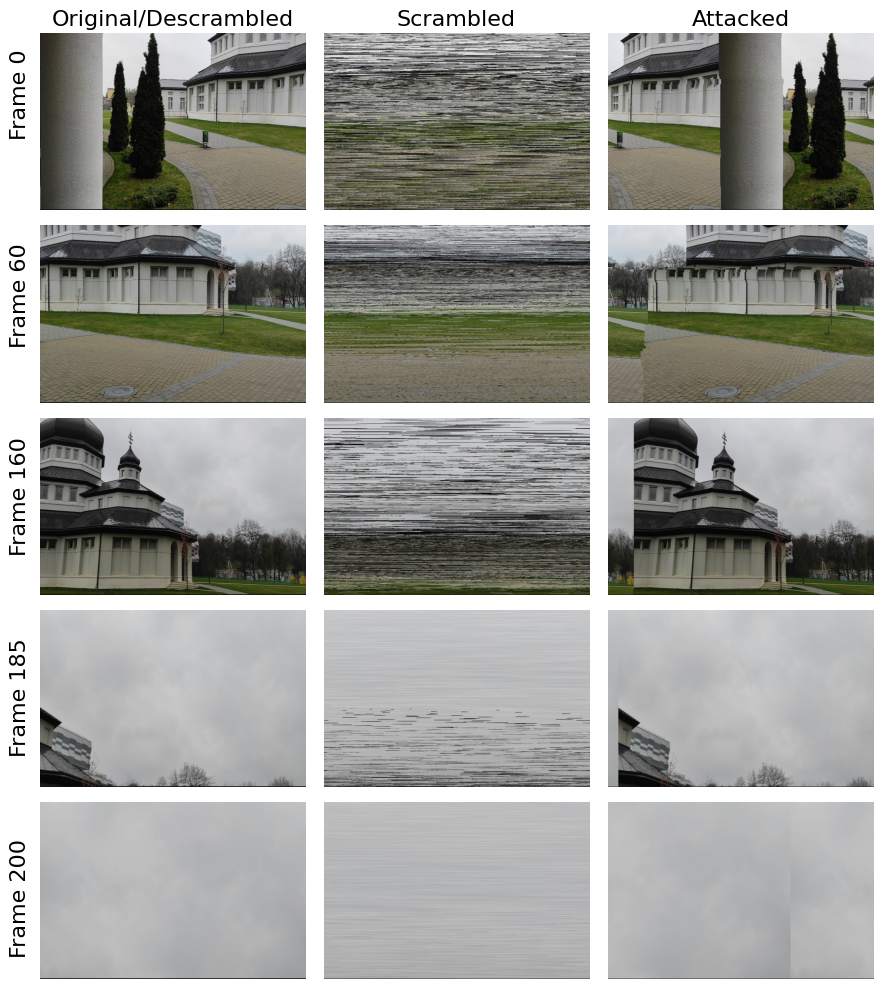

In [106]:
plot_frame_arrays([descrambled_frames, [cv2.cvtColor(i, cv2.COLOR_YCrCb2BGR) for i in frames_converted], [cv2.cvtColor(i, cv2.COLOR_YCrCb2BGR) for i in attacked_frames]], selected_frames, ["Original/Descrambled", "Scrambled", "Attacked"], save=True)

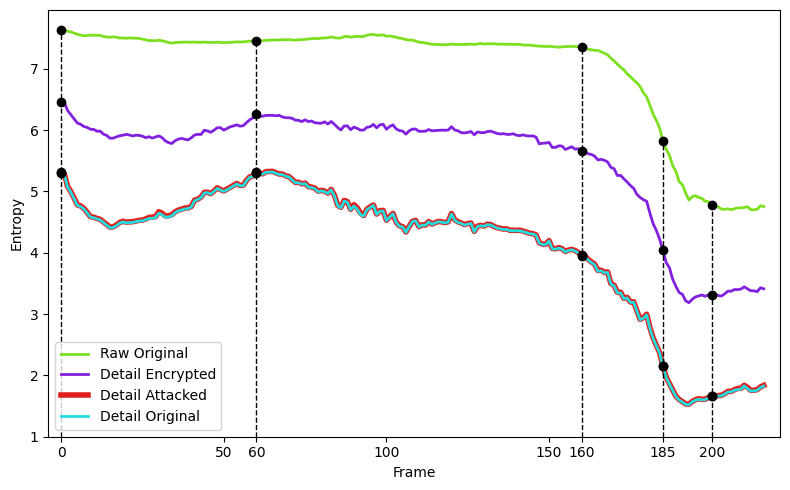

In [96]:
raw = np.array(raw_decrypted_entropy)
enc = np.array(encrypted_entropy)


plt.figure(figsize=(8, 5))
linewidth = 2
plt.plot(raw, label="Raw Original", color="#7DDF20", linewidth=linewidth)
plt.plot(enc, label="Detail Encrypted",  color="#8220DF", linewidth=linewidth )
plt.plot(attacked_entropy, label="Detail Attacked",  color="#DF2220", linewidth=linewidth * 2 )
plt.plot(decrypted_entropy, label="Detail Original",  color="#20DDDF", linewidth=linewidth)


plt.xlabel("Frame")
plt.ylabel("Entropy")
plt.legend()

# Vertical dashed lines and intersection markers
for frame in selected_frames:
    y_max = max(raw[frame], enc[frame])
    plt.vlines(x=frame, ymin=1, ymax=y_max, color='black', linestyle='--', linewidth=1)

    plt.plot(frame, attacked_entropy[frame], 'o', color='black')
    plt.plot(frame, decrypted_entropy[frame], 'o', color='black')
    plt.plot(frame, raw[frame], 'o', color='black')
    plt.plot(frame, enc[frame], 'o', color='black')


# Update x-ticks to include selected frame numbers
xticks = plt.xticks()[0]
xticks = np.union1d(xticks, selected_frames)
plt.xticks(xticks, [str(int(x)) for x in xticks])

# Remove the space before frame 0
plt.xlim(left=-4, right = len(raw) + 4)
plt.ylim(1)
plt.tight_layout()
# plt.title("Entropy per frame (Church)")
plt.savefig("entropy.pdf", format="pdf")
plt.show()

In [97]:
np.sum((np.array(attacked_entropy) - np.array(decrypted_entropy)) ** 2) / len(decrypted_entropy)

0.00010022054231481115

In [347]:
np.sum((np.array(raw_decrypted_entropy) - np.array(encrypted_entropy)) ** 2) / len(decrypted_entropy)

0.025999390035181

## Trying to get something useful from edge detection

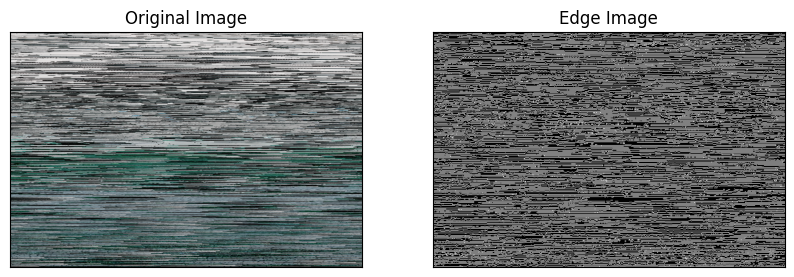

In [25]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = frame
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

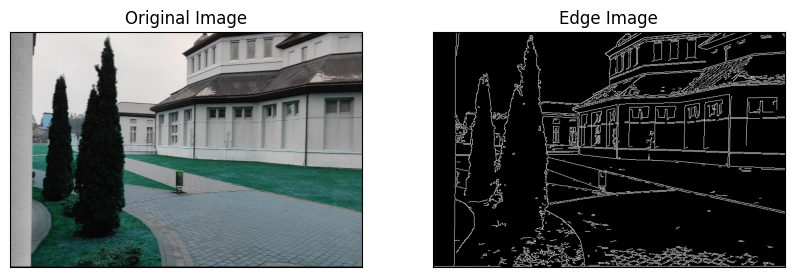

In [39]:
img = frame_normal
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [53]:
cv2.getGaussianKernel(5, 1).T[0]

array([0.05448868, 0.24420134, 0.40261995, 0.24420134, 0.05448868])

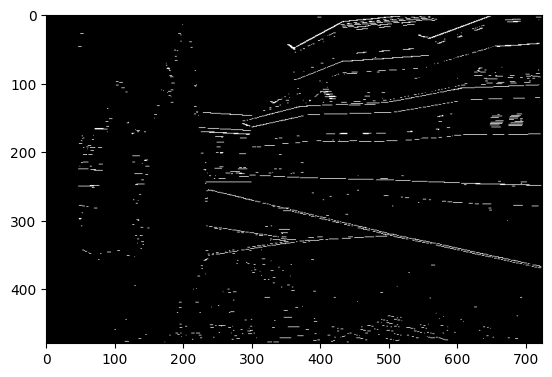

In [74]:
kernel = cv2.getGaussianKernel(5, 5).T[0]
img = np.diff([np.convolve(i, kernel) for i in cv2.cvtColor(frame_normal, cv2.COLOR_BGR2GRAY)], axis=0)
img[img < 30] = 0
img[img >= 30] = 255
plt.imshow(img, cmap="gray")

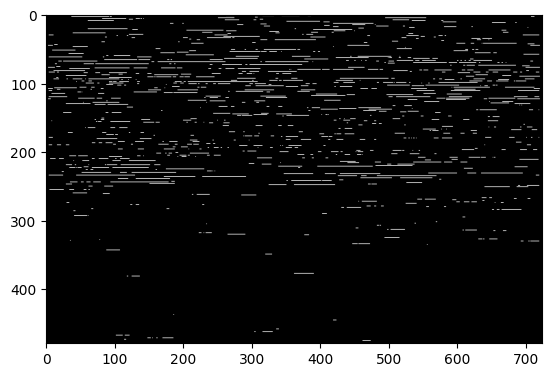

In [83]:
kernel = cv2.getGaussianKernel(5, 5).T[0]
img = np.diff([np.convolve(i, kernel) for i in cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)], axis=0)
thresh = 150
img[img < thresh] = 0
img[img >= thresh] = 255
plt.imshow(img, cmap="gray")

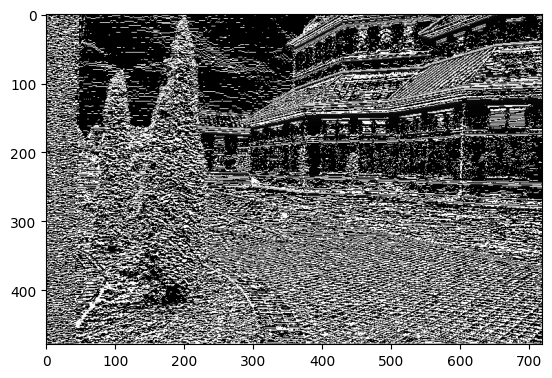

In [41]:
plt.imshow(np.diff(cv2.cvtColor(frame_normal, cv2.COLOR_BGR2GRAY), axis=0), cmap="gray")

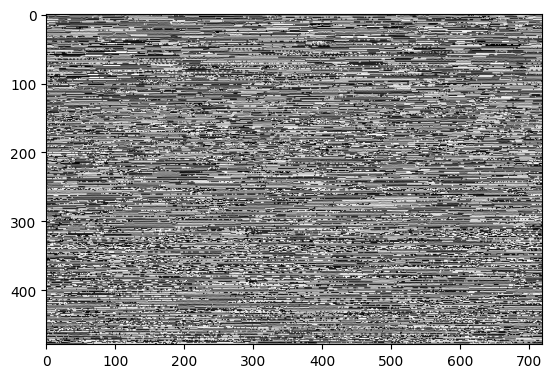

In [40]:
plt.imshow(np.diff(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), axis=0), cmap="gray")

## Trying to use other converter's output

In [224]:
all_video = []
with open("yuv422p.yuv", "rb") as f:
    all_video = f.read(720 * 2 * 480 * 4)

In [225]:
all_video = np.array([int(i) for i in all_video], dtype=np.uint8)

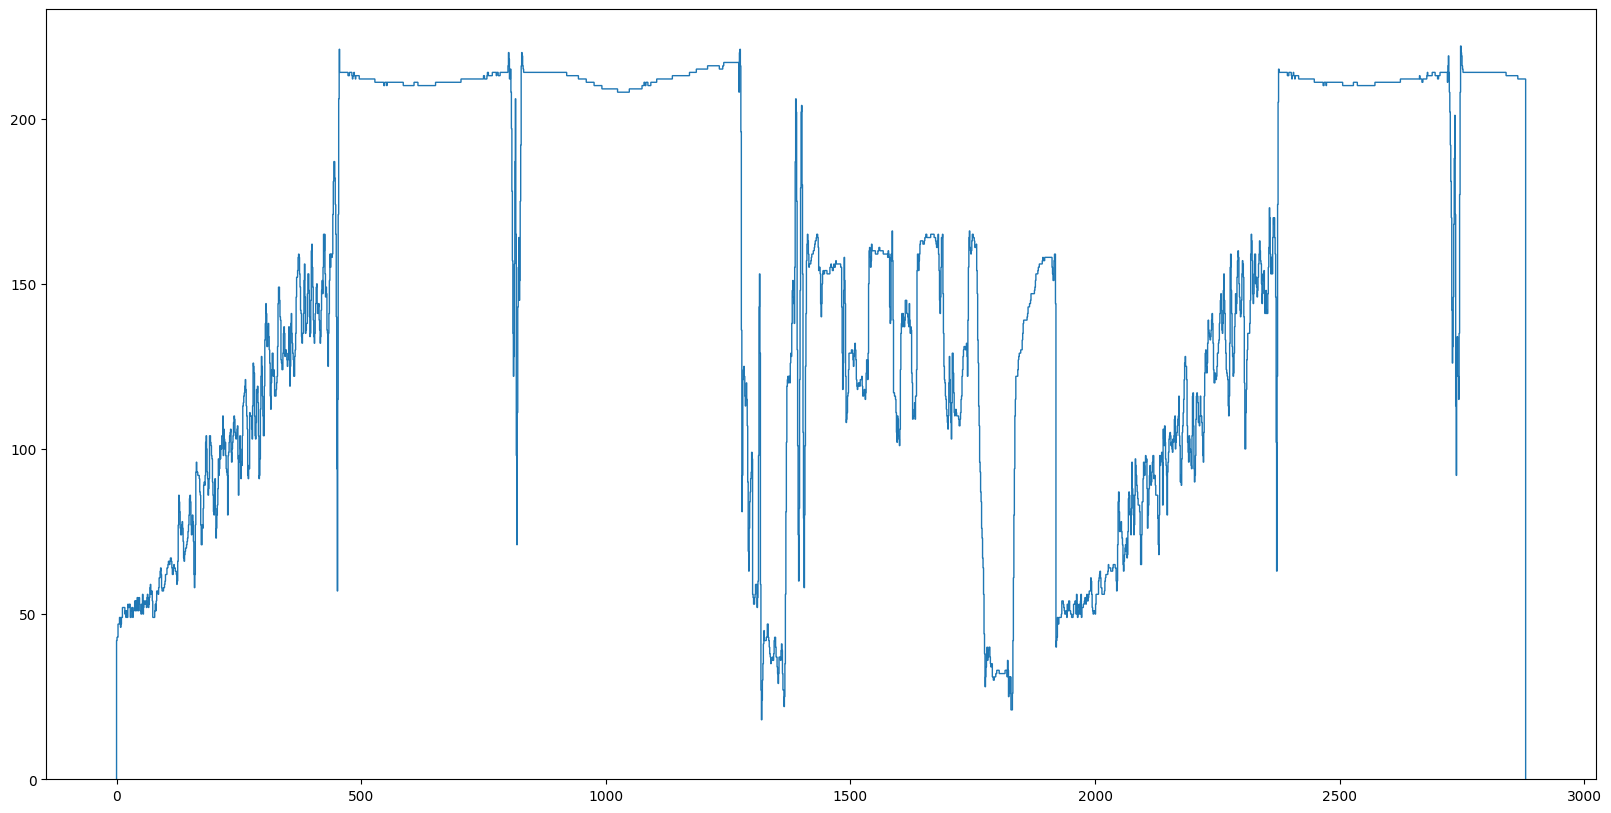

In [226]:
plt.figure(figsize=(20,10))
plt.stairs(all_video[1:720 * 8:2])

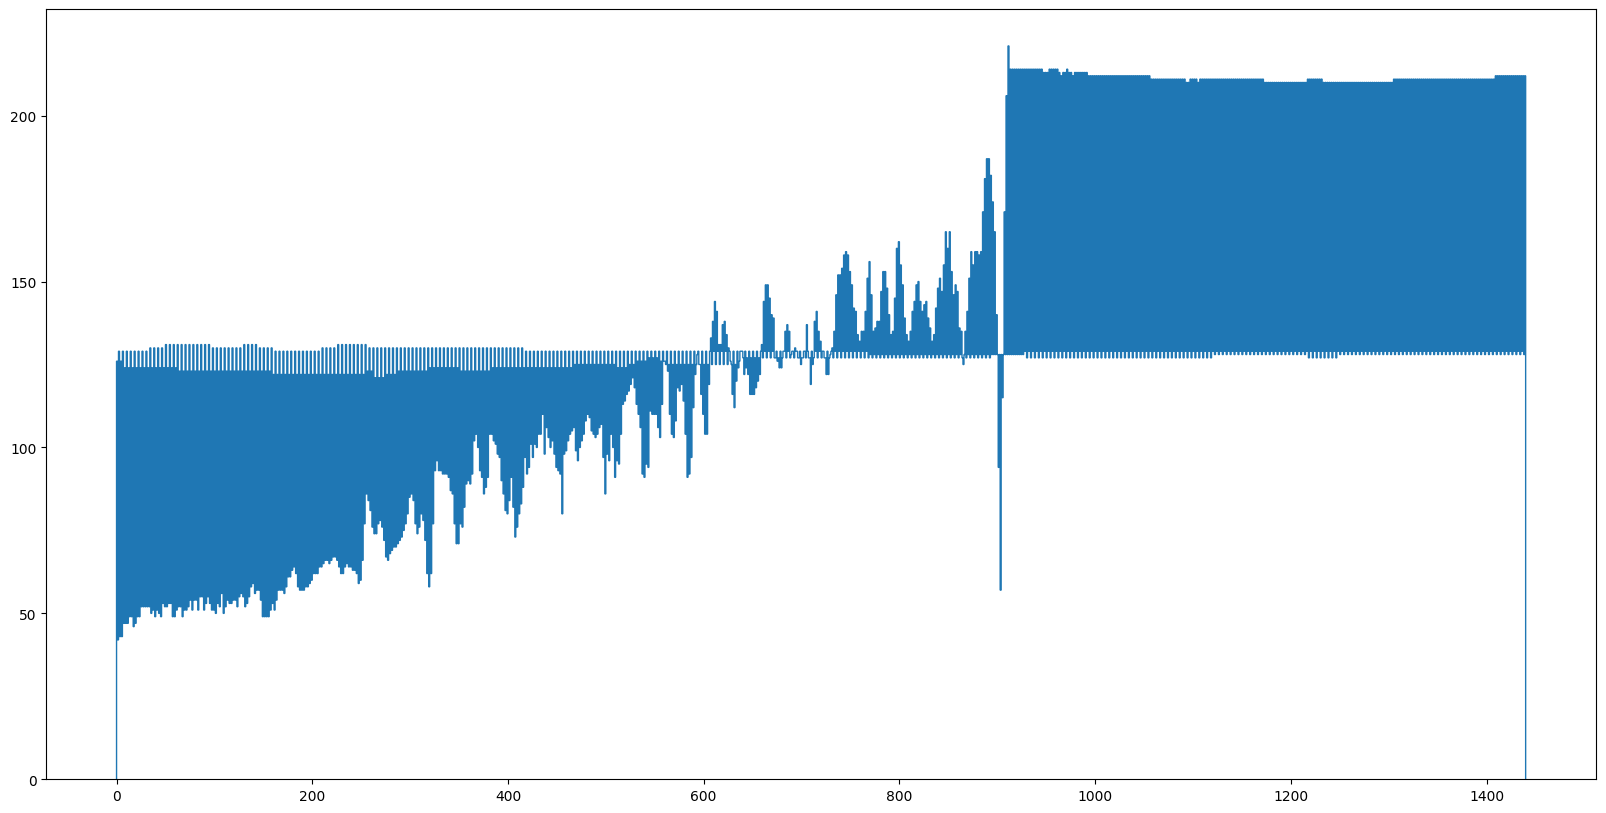

In [227]:
plt.figure(figsize=(20,10))
plt.stairs(all_video[:720*2])

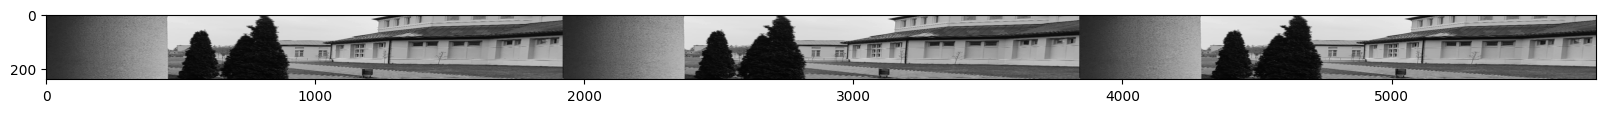

In [230]:
all_video_reshaped = all_video[1::2].reshape((-1, 720 * 8 ))
plt.figure(figsize=(20,10))

plt.imshow(all_video_reshaped, cmap="gray")

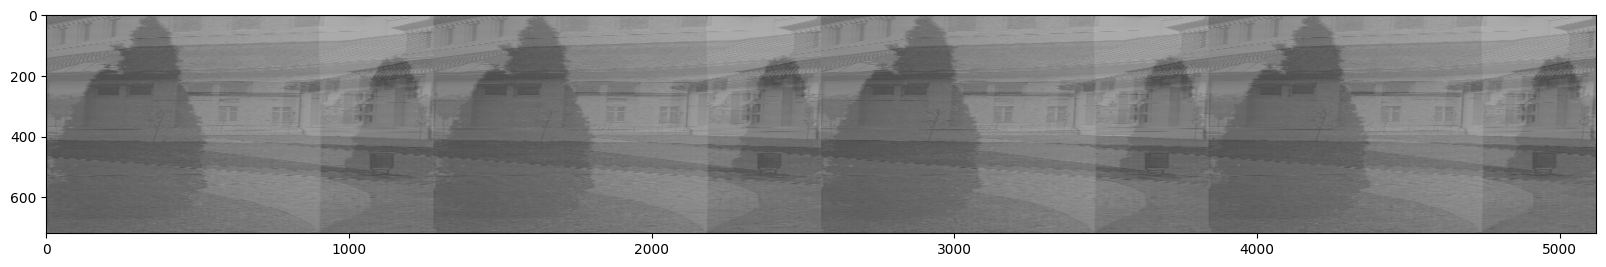